## Shear bands

This series of notebook explores shear band emergence. The models are based on 


Spiegelman, Marc, Dave A. May, and Cian R. Wilson. "On the solvability of incompressible Stokes with viscoplastic rheologies in geodynamics." Geochemistry, Geophysics, Geosystems (2016).

We first implement the instantaneous model described in that paper, and then look at the at series of extensions

* mohr-coloumb criteria as in kaus 

* transverse isotropic plasticity

* elasticity

* sticky air vs neumann


* time dependence, hardening/softening

questions:

* how do we get the plastic part of the strain
* can we control the solver - i.e do the Picard iterations manually
* how should we do the pressure split for long term models?
    * track the surface and integrate down, or do a 'static solve'
    
    
    
## Scaling

Of course, the magnitude of the nonlinear residual will depend on how the problem is scaled and we find that it is useful to scale variables such that they are roughly O(1) when solving. For this problem, we scale velocities by U0, viscosities by g051022 Pa s, and stresses/pressures by g0U0=H where H 

### NOTES

   1) This notebook also introduces Lagrangian integration with higher order elements. In this case it is necessary to  manually introduce the swarm population manager and explicitly call for the re-population of the elements after the particles have been advected.
   
   2) The mesh is deformed to follow the moving boundaries. This is an ALE problem in which the material history attached to the particles and the boundary-deformation history is attached to the mesh. 
   
   3) There is no thermal component to this notebook and hence no ALE correction for the moving mesh applies to the advection term.


In [119]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [120]:
#####
#Stubborn version number conflicts - For now...
#####
try:
    natsort.natsort = natsort.natsorted
except:
    natsort.natsort = natsort.natsort

#In case NN swarm interpolation is required

from scipy.spatial import cKDTree as kdTree

def nn_evaluation(fromSwarm, toSwarm, n=1, weighted=False):
    """
    This function provides nearest neighbour information for uw swarms, 
    given the "toSwarm", this function returns the indices of the n nearest neighbours in "fromSwarm"
    it also returns the inverse-distance if weighted=True. 
    
    The function works in parallel.
    
    The arrays come out a bit differently when used in nearest neighbour form
    (n = 1), or IDW: (n > 1). The examples belowe show how to fill out a swarm variable in each case. 
    
    
    Usage n == 1:
    ------------
    ix, weights = nn_evaluation(swarm, data, n=1, weighted=False)
    toSwarmVar.data[:][:,0] = np.average(fromSwarmVar[ix][:,0], weights=weights)
    
    Usage n > 1:
    ------------
    ix, weights = nn_evaluation(swarm, data, n=2, weighted=False)
    toSwarmVar.data[:][:,0] =  np.average(fromSwarmVar[ix][:,:,0], weights=weights, axis=1)
    
    """
    
    
    if len(toSwarm) > 0: #this is required for safety in parallel
        
        #this should avoid building the tree again when this function is called multiple times.
        try:
            tree = fromSwarm.tree
            #print(1)
        except:
            #print(2)
            fromSwarm.tree = kdTree(fromSwarm.particleCoordinates.data)
            tree = fromSwarm.tree
        d, ix = tree.query(toSwarm, n)
        if n == 1:
            weights = np.ones(toSwarm.shape[0])
        elif not weighted:
            weights = np.ones((toSwarm.shape[0], n))*(1./n)
        else:
            weights = (1./d[:])/(1./d[:]).sum(axis=1)[:,None]
        return ix,  weights 
    else:
        return [], []

Model name and directories
-----

In [121]:
############
#Model name 
############

#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [122]:
###########
#Standard output directory setup
###########

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

## Set parameter dictionaries

* Parameters are stored in dictionaries. 
* If params are passed in as flags to the script, they overwrite 


In [123]:
###########
#Store the physical parameters, scale factors and dimensionless paramters in easyDicts
###########

#dp : dimensional paramters
dp = edict({})
dp.depth=30*1e3                #domain depth
dp.asthenosphere=(30.*1e3)/4   #level from bottom of model,
dp.eta1=1e24
dp.eta2=1e20
dp.etaMin=1e18
dp.U0=0.0025/(3600*24*365)     #m/s speigelman et al
dp.rho=2700.                   #kg/m3
dp.g=9.81
dp.cohesion=40e6               #kaus
dp.cohesion=100e6              #speigelman et al
dp.cohesion=60e6 
dp.fa=30.                      #friction angle degrees
dp.a=1.                        #fraction of the dynamic pressure to allow in the model
dp.notchWidth = dp.depth/16.



#md : Modelling choices and Physics switches
md = edict({})        
md.refineMesh=False
md.stickyAir=False
md.aspectRatio=4.
md.res=64
md.ppc=25
md.tol=1e-10
md.maxIts=50
md.perturb=0 # 0 for material heterogeneity, 1 for cohesion weakening

In [124]:
###########
#If command line args are given, overwrite the above paramter dictionaries 
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [125]:
#In this code block we map the dimensional paramters to dimensionless, through scaling factors




#sf : scaling factors

sf = edict({})
sf.LS = 30*1e3
sf.eta0 = 1e21
sf.stress = (sf.eta0*dp.U0)/sf.LS
sf.vel = dp.U0
sf.density = sf.LS**3
sf.g = dp.g
sf.rho = (sf.eta0*dp.U0)/(sf.LS**2*dp.g)

#ndp : non dimensional parameters
ndp = edict({})
ndp.depth = dp.depth/sf.LS
ndp.U0 = dp.U0/sf.vel
ndp.asthenosphere = dp.asthenosphere/sf.LS
ndp.eta1 = dp.eta1/sf.eta0
ndp.eta2 = dp.eta2/sf.eta0
ndp.etaMin = dp.etaMin/sf.eta0
ndp.cohesion = (dp.cohesion/sf.stress)*np.cos(np.radians(dp.fa))
ndp.fa = math.sin(np.radians(dp.fa)) #friction coefficient
ndp.g = dp.g/sf.g
ndp.rho = dp.rho/sf.rho
ndp.notchWidth = dp.notchWidth/sf.LS
ndp.a = dp.a
            


Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [126]:

minX  = -0.5*md.aspectRatio
maxX  =  0.5*md.aspectRatio
maxY  = ndp.depth
meshV =  1.0

if md.stickyAir:
    maxY  = 1.1


resY = int(md.res)
resX = int(resY*md.aspectRatio)

elementType="Q2/dPc1"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, 0.), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Pure shear with moving  walls — all boundaries are zero traction with 

In [127]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]

allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (iWalls, base) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [ndp.U0, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [ -ndp.U0, 0.]
    

### Setup the material swarm and passive tracers

The material swarm is used for tracking deformation and history dependence of the rheology

Passive swarms can track all sorts of things but lack all the machinery for integration and re-population

In [128]:
swarm  = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=int(md.ppc) )
swarm.populate_using_layout( layout=swarmLayout )

# create pop control object
pop_control = uw.swarm.PopulationControl(swarm)

surfaceSwarm = uw.swarm.Swarm( mesh=mesh )


### Create a particle advection system

Note that we need to set up one advector systems for each particle swarm (our global swarm and a separate one if we add passive tracers).

In [129]:
advector        = uw.systems.SwarmAdvector( swarm=swarm,            velocityField=velocityField, order=2 )
advector2       = uw.systems.SwarmAdvector( swarm=surfaceSwarm,     velocityField=velocityField, order=2 )


### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [130]:
# Tracking different materials

materialVariable = swarm.add_variable( dataType="int", count=1 )


# plastic deformation for weakening

plasticStrain  = swarm.add_variable( dataType="double",  count=1 )



# passive markers at the surface

surfacePoints = np.zeros((1000,2))
surfacePoints[:,0] = np.linspace(minX+0.01, maxX-0.01, 1000)
surfacePoints[:,1] = 1.0 #

surfaceSwarm.add_particles_with_coordinates( surfacePoints )
yvelsurfVar = surfaceSwarm.add_variable( dataType="double", count=1)


### Initialise swarm variables


In [131]:
yvelsurfVar.data[...] = (0.)
materialVariable.data[...] = 0
plasticStrain.data[...] = 0

### Material distribution in the domain.



In [132]:
# Initialise the 'materialVariable' data to represent different materials. 
material1 = 1 # viscoplastic
material0 = 0 # accommodation layer a.k.a. Sticky Air
material2 = 2 # Under layer 


materialVariable.data[:] = 0.

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.

coord = fn.input()

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.



#notchWidth = (1./32.) * md.notch_fac

notchCond = operator.and_(coord[1] < ndp.asthenosphere + ndp.notchWidth, operator.and_(coord[0] < ndp.notchWidth, coord[0] > -1.*ndp.notchWidth )  )

mu = ndp.notchWidth
sig =  0.25*ndp.notchWidth
gausFn1 = ndp.notchWidth*fn.math.exp(-1.*(coord[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere
mu = -1.*ndp.notchWidth
gausFn2 = ndp.notchWidth*fn.math.exp(-1.*(coord[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere

conditions = [ (       coord[1] > 1.0 , material0 ), #air
               (       coord[1] < ndp.asthenosphere , material2 ), #asthenosphere
               (       coord[1] < gausFn1 , material2 ), #asthenosphere
               (       coord[1] < gausFn2 , material2 ), #asthenosphere       

               (       notchCond , material2 ),
               (       True ,           material1 ) ]  #visco-plastic

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.


if md.perturb == 0:
    materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)
    
else: 
    #in this case just build the asphenosphere
    materialVariable.data[:] = material1
    materialVariable.data[np.where(swarm.particleCoordinates.data[:,1] < ndp.asthenosphere)] = material2
    
    

In [133]:
figMat = glucifer.Figure( figsize=(1200,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figMat.append( glucifer.objects.Points(swarm,materialVariable, pointSize=2.0) )
figMat.append( glucifer.objects.Mesh(mesh))
#figMat.show()

## Buoyancy forces

In this example, no buoyancy forces are included in the Stokes system, the Pressures that appear are dynamic (p'). We add the appropriate lithostatic component to the Drucker-prager yield criterion.

In [134]:
lithPressureFn = ndp.rho* (1. - coord[1])


## Rheology

In [135]:
##Background viscosity

#ndp.etaMin    #if sticky air
#ndp.eta1
#ndp.eta2


### Define a yield criterion (function)

\begin{equation}
    \tau_\textrm{yield} = \cos(\phi)C(\varepsilon_p) + \sin(\phi(\varepsilon_p))( p_{lith} + \alpha P') 
\end{equation}

The yield strength described above needs to be evaluated on the fly at the particles (integration points). It therefore needs to be a function composed of mesh variables, swarm variables, constants, and mathematical operations.

In [136]:
# plastic strain - weaken a region at the base close to the boundary (a weak seed but through cohesion softening)

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

def boundary(xx, minX, maxX, width, power):
    zz = (xx - minX) / (maxX - minX)
    return (np.tanh(zz*width) + np.tanh((1.0-zz)*width) - math.tanh(width))**power

# weight = boundary(swarm.particleCoordinates.data[:,1], 10, 4) 

if md.perturb != 0: #build a heterogenity into the cohesion, through the accumulated plastic strain term

    #plasticStrain.data[:] = 0.5 * np.random.rand(*plasticStrain.data.shape[:])
    plasticStrain.data[:] = np.random.normal(loc=0.5, scale=0.05,size = plasticStrain.data.shape[:])
    plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,0], 0.0, ndp.notchWidth) 
    plasticStrain.data[:,0] *= gaussian(swarm.particleCoordinates.data[:,1], ndp.asthenosphere, ndp.notchWidth/2.) 
    plasticStrain.data[:,0] *= boundary(swarm.particleCoordinates.data[:,0], minX, maxX, 10.0, 2)
    plasticStrain.data[:,0][np.where(swarm.particleCoordinates.data[:,1] < ndp.asthenosphere)] = 0.

# 



In [137]:
#if uw.nProcs() == 1:   # Serial
#    xx = np.arange(-2, 2, 0.01)
#    yy = boundary(xx, minX, maxX, 10., 2.)
#    pyplot.scatter(xx,yy)

In [138]:
# Friction - in this form it can also be made to weaken with strain

cohesion0       = fn.misc.constant(ndp.cohesion)
cohesionInf = 0.25*cohesion0
refStrain = 0.5

# Drucker-Prager yield criterion

weakenedCohesion = cohesion0+ (cohesionInf - cohesion0)*fn.misc.min(1., plasticStrain/refStrain) 

yieldStressFn   = weakenedCohesion  + ndp.fa *(lithPressureFn + ndp.a*pressureField ) 

#yieldStressFn   = cohesionFn + ndp.fa *(lithPressureFn + ndp.a*fn.misc.max(fn.misc.constant(0.), pressureField) ) #in this case only positive dynamic pressures


# first define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

# now compute a viscosity assuming yielding

#min_viscosity = visc0  # same as the air ... 

yieldingViscosityFn =  0.5 * yieldStressFn / (strainRate_2ndInvariantFn+1.0e-18)

#viscosityFn = fn.exception.SafeMaths( fn.misc.max(fn.misc.min(yieldingViscosityFn, 
#                                                              backgroundViscosityFn), 
#                                                  min_viscosity))


compositeviscosityFn = fn.exception.SafeMaths( fn.misc.max(
                                              1./((1./yieldingViscosityFn) + (1./ndp.eta1))
                                             , ndp.etaMin))


In [139]:
viscosityMap = { material0: ndp.etaMin, material1:compositeviscosityFn, material2:ndp.eta2 }

viscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                           mapping = viscosityMap )

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [140]:
stokes = uw.systems.Stokes(    velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = velocityBCs,
                               fn_viscosity  = viscosityFn)

solver = uw.systems.Solver( stokes )

# "mumps" is a good alternative for "lu" but  # use "lu" direct solve and large penalty (if running in serial)

if(uw.nProcs()==1):
    solver.set_inner_method("lu")
    solver.set_penalty(1.0e7) 
    solver.options.scr.ksp_rtol = 1.0e-7
    solver.options.scr.ksp_rtol = 1.0e-4


else:
    solver.set_inner_method("mumps")
    solver.set_penalty(1.0e7)
    solver.options.scr.ksp_type="cg"
    solver.options.scr.ksp_rtol = 1.0e-4



In [141]:
#solver.solve( nonLinearIterate=True, nonLinearMaxIterations=20)

In [142]:
#solver._stokesSLE._cself.curResidual

## Manual Picard iteration

In [143]:

#dynPressure = pressureField - lithPressureFn

In [144]:
prevVelocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )

#dynPressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh,         nodeDofCount=1)
prevPressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh,         nodeDofCount=1)


prevVelocityField.data[:] = (0., 0.)
#dynPressureField.data[:] = 0.
prevPressureField.data[:] = 0.

In [145]:
def volumeint(Fn = 1., rFn=1.):
    return uw.utils.Integral( Fn*rFn,  mesh )


In [146]:
#md.maxIts = 5.

In [147]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

(area,) = surfaceArea.evaluate()


In [148]:
#The underworld Picard interation applies the following residual (SystemLinearEquations.c)

#/* Calculate Residual */
#      VecAXPY( previousVector, -1.0, currentVector );
#      VecNorm( previousVector, NORM_2, &prevVecNorm );
#      VecNorm( currentVector, NORM_2, &currVecNorm );
#      residual = ((double)prevVecNorm) / ((double)currVecNorm);



count = 0


res1Vals = []
res2Vals = []
res3Vals = []

for i in range(int(md.maxIts)):
    
    prevVelocityField.data[:] = velocityField.data.copy()
    prevPressureField.data[:] = pressureField.data[:] 

    
    solver.solve( nonLinearIterate=False)
    
    #remove drift in the pressure
    (p0,) = surfacePressureIntegral.evaluate() 
    pressureField.data[:] -= p0 / area
    
    #Update the dynamic pressure variable
    #dynPressureField.data[:] = pressureField.data[:] - lithPressureFn.evaluate(mesh.subMesh)
    
    
    ####
    #Caluclate a range of norms to assess convergence
    ####
    
    #L2 norm of current velocity
    v2 = fn.math.dot(velocityField,  velocityField)
    _Vr = volumeint(v2)
    velL2 = np.sqrt(_Vr.evaluate()[0])
    
    
    #L2 norm of delta velocity
    
    delV = velocityField - prevVelocityField
    v2 = fn.math.dot(delV,  delV)
    _Vr = volumeint(v2)
    delvelL2 = np.sqrt(_Vr.evaluate()[0])
    
    
    #L2 norm of current dynamic pressure
    p2 = fn.math.dot(pressureField, pressureField)
    _Pr = volumeint(p2)
    pL2 = np.sqrt(_Pr.evaluate()[0])
    
    
    #L2 norm of delta dynamic pressure
    delP = pressureField - pressureField
    p2 = fn.math.dot(delP,  delP)
    _Pr = volumeint(p2)
    delpL2 = np.sqrt(_Pr.evaluate()[0])
    
    #Full norm of the primal variables
    
    x2 = fn.math.dot(velocityField,  velocityField) + fn.math.dot(pressureField, pressureField)
    _Xr = volumeint(x2)
    xL2 = np.sqrt(_Xr.evaluate()[0])
    
    #Full norm of the change in primal variables
    
    delV = velocityField - prevVelocityField
    delP = pressureField - prevPressureField
    x2 = fn.math.dot(delV,  delV) + fn.math.dot(delP, delP)
    _Xr = volumeint(x2)
    delxL2 = np.sqrt(_Xr.evaluate()[0])
    
    
    
    res1 = abs(delvelL2 /velL2)
    res1Vals .append(res1)
    
    res2 = abs(delpL2 /pL2)
    res2Vals .append(res2)
    
    res3 = abs(delxL2 /xL2)
    res3Vals .append(res3)

    
    count +=1
    print(res1, res2, res3)
    print(count)
    
    
    #Converged stopping condition
    if res1 < md.tol:
        break


(0.9982689534337611, 0.0, 0.9999999961091065)
1
(0.14782800880084901, 0.0, 5.3180987985933008)
2
(0.037568289201951828, 0.0, 0.25556134046321927)
3
(0.03921736317630875, 0.0, 0.095420326755013954)
4
(0.030378321898458387, 0.0, 0.043209771613547214)
5


In [149]:
#solver._stokesSLE._cself.curResidual


In [150]:
#%pylab inline

#fig, ax = plt.subplots()
#ax.scatter(range(len(resVals)), resVals)
#ax.set_yscale('log')
#ax.set_ylim(0.0005, 1.)

In [151]:
#((20e3*1e-15)*3600*365*24)*100.

## Figures


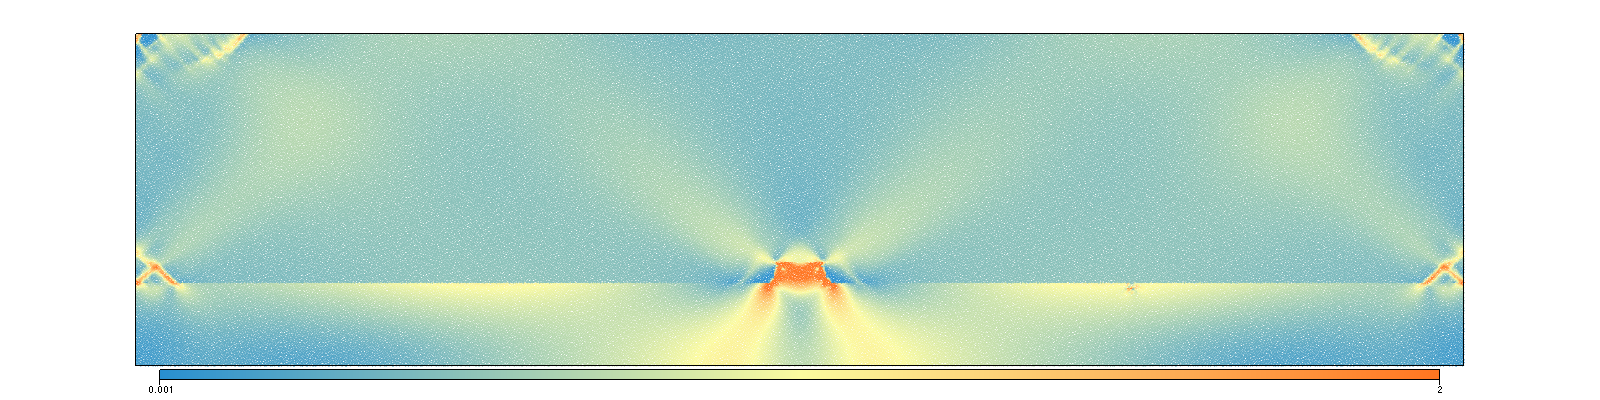

In [153]:
figSinv = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )

#figSinv .append( glucifer.objects.Points(swarm,plasticStrain, pointSize=2.0) )
figSinv .append( glucifer.objects.Points(swarm,strainRate_2ndInvariantFn, pointSize=2.0, valueRange=[1e-3, 2.]) )
#figSinv .append( glucifer.objects.Points(swarm,strainRate_2ndInvariantFn, pointSize=2.0) )
#figSinv.show()

In [62]:
figVisc = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )

figVisc.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.25, scaling=.075, resolutionI=32, resolutionJ=8) )


#figVisc.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=2.0, logScale=True ) )
figVisc.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=2.0, logScale=True ,valueRange=[5., 500]) )

#figVisc.show()

In [60]:
#viscosityFn.evaluate(swarm).min()

In [385]:
#viscosityFn.evaluate([0.5, 0.5])
#velocityField.evaluate([0.5, 0.5])


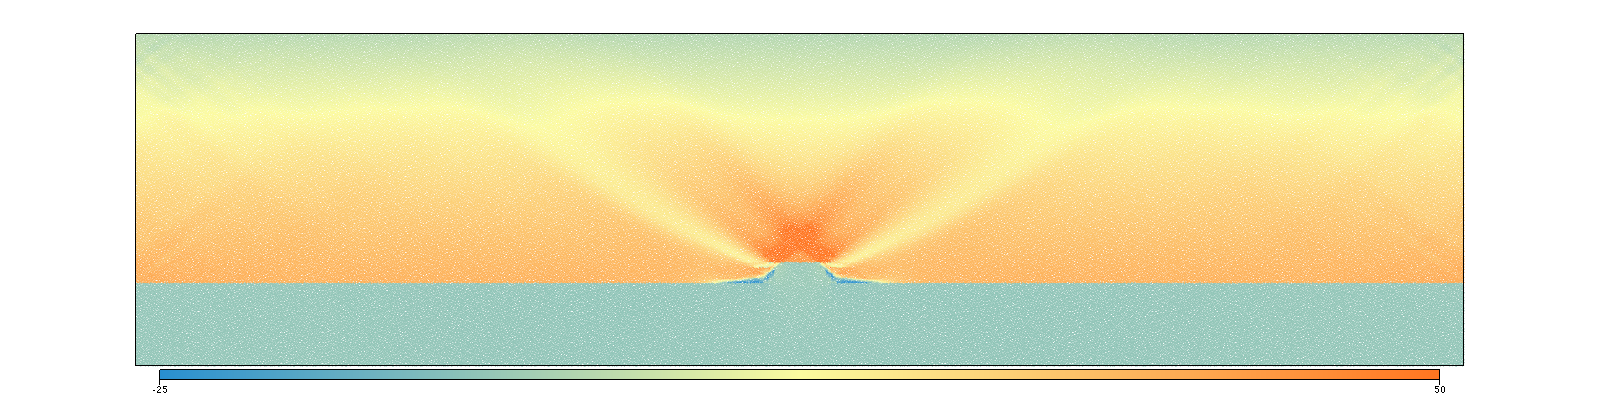

In [55]:
figPres= glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )

#figPres.append( glucifer.objects.Points(swarm, dynPressure,pointSize=2.0, valueRange=[-1.,2.5] ))
#figPres.append( glucifer.objects.Points(swarm, pressureField,pointSize=2.0))
figPres.append( glucifer.objects.Points(swarm, pressureField,pointSize=2.0, valueRange=[-25.,50.] ))

#figPres.draw.label(r'$\sin (x)$', (0.2,0.7,0))
#figPres.append( glucifer.objects.Mesh(mesh,opacity=0.2))

#figPres.show()

In [387]:
#figSinv.save_image(imagePath + "figSinv.png")
figVisc.save_image(imagePath +  "figVisc.png")
figPres.save_image(imagePath + "figPres.png")

'results/T/0/images/figPres.png'

In [388]:
velocityField.save(filePath + "vel.h5")
pressureField.save(filePath + "pressure.h5")

In [389]:
yvelsurfVar.data[...] = velocityField[1].evaluate(surfaceSwarm)
yvelsurfVar.save(filePath + "yvelsurf.h5")

## Save points to determine shear band angle

In [390]:
eii_mean = uw.utils.Integral(strainRate_2ndInvariantFn,mesh).evaluate()[0]/4.

eii_std = uw.utils.Integral(fn.math.sqrt(0.25*(strainRate_2ndInvariantFn - eii_mean)**2.), mesh).evaluate()[0]


In [391]:
#grab all of material points that are above 2 sigma of mean strain rate invariant



xv, yv = np.meshgrid(
        np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0]), 
        np.linspace(mesh.minCoord[1], mesh.maxCoord[1], mesh.elementRes[1]))

meshGlobs = np.row_stack((xv.flatten(), yv.flatten())).T


#Calculate the 2-sigma value of the strain rate invariant function (
#we use this a definition for a shear band)
eII_2sig = eii_mean  + 2.*eii_std

In [392]:
shearbandswarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
shearbandswarmlayout  = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=shearbandswarm , particlesPerCell=int(md.ppc/16.) )
shearbandswarm.populate_using_layout( layout=shearbandswarmlayout )

In [393]:
#shearbandswarm.particleGlobalCount

In [394]:
np.unique(strainRate_2ndInvariantFn.evaluate(shearbandswarm) < eII_2sig)

array([False,  True], dtype=bool)

In [395]:
with shearbandswarm.deform_swarm():
    mask = np.where(strainRate_2ndInvariantFn.evaluate(shearbandswarm) < eII_2sig)
    shearbandswarm.particleCoordinates.data[mask[0]]= (1e20, 1e20)

shearbandswarm.update_particle_owners()    

with shearbandswarm.deform_swarm():
    mask = np.where((shearbandswarm.particleCoordinates.data[:,1] < ndp.asthenosphere + ndp.notchWidth) | 
                    (shearbandswarm.particleCoordinates.data[:,1] >  1. - ndp.notchWidth) |
                    (shearbandswarm.particleCoordinates.data[:,0] <  minX/1.5))
    shearbandswarm.particleCoordinates.data[mask]= (1e20, 1e20)

shearbandswarm.update_particle_owners()


with shearbandswarm.deform_swarm():
    mask = np.where(shearbandswarm.particleCoordinates.data[:,0] > -2.*ndp.notchWidth)
    shearbandswarm.particleCoordinates.data[mask]= (1e20, 1e20)
                    
shearbandswarm.update_particle_owners()

In [396]:
shearbandswarm.save(filePath + 'swarm.h5')


## Calculate and save some metrics

In [397]:
#We'll create a function that based on the strain rate 2-sigma value. 
#Use this to estimate thickness and average pressure within the shear band

conds = [ ( (strainRate_2ndInvariantFn >  eII_2sig) & (coord[1] > ndp.asthenosphere + ndp.notchWidth), 1.),
            (                                           True , 0.) ]


conds2 = [ ( (strainRate_2ndInvariantFn <  eII_2sig) & (coord[1] > ndp.asthenosphere + ndp.notchWidth), 1.),
            (                                           True , 0.) ]


# lets also integrate just one eighth of sphere surface
_2sigRest= fn.branching.conditional( conds ) 

_out2sigRest= fn.branching.conditional( conds2 ) 

In [398]:
sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
#sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))
vd = 4.*viscosityFn*strainRate_2ndInvariantFn # there's an extra factor of 2, which is necessary because the of factor of 0.5 in the UW second invariant 


_rmsint = uw.utils.Integral(sqrtv2, mesh)

#_rmsSurf = uw.utils.Integral(sqrtv2x, mesh, integrationType='Surface',surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

_viscMM = fn.view.min_max(viscosityFn)
dummyFn = _viscMM.evaluate(swarm)

_eiiMM = fn.view.min_max(strainRate_2ndInvariantFn)
dummyFn = _eiiMM.evaluate(swarm)

#Area and pressure integrals inside / outside shear band

_shearArea = uw.utils.Integral(_2sigRest, mesh)
_shearPressure = uw.utils.Integral(_2sigRest*pressureField, mesh)

_backgroundArea = uw.utils.Integral(_out2sigRest, mesh)
_backgroundPressure = uw.utils.Integral(_out2sigRest*pressureField, mesh)

#dissipation 

_vdint  = uw.utils.Integral(vd,mesh)
_shearVd  = uw.utils.Integral(vd*_2sigRest,mesh)
_backgroundVd  = uw.utils.Integral(vd*_out2sigRest,mesh)

#dynamic pressure min / max

_press = fn.view.min_max(pressureField)
dummyFn = _press.evaluate(swarm)

In [399]:
#_viscMM.min_global(), _viscMM.max_global()
#_eiiMM.min_global(), _eiiMM.max_global()

rmsint = _rmsint.evaluate()[0]

shearArea = _shearArea.evaluate()[0]
shearPressure = _shearPressure.evaluate()[0]

backgroundArea = _backgroundArea.evaluate()[0]
backgroundPressure = _backgroundPressure.evaluate()[0]

vdint = _vdint.evaluate()[0]
shearVd = _shearVd.evaluate()[0]
backgroundVd = _backgroundVd.evaluate()[0]


viscmin = _viscMM.min_global()
viscmax = _viscMM.max_global()
eiimin = _eiiMM.min_global()
eiimax = _eiiMM.max_global()

pressmax = _press.max_global()
pressmin = _press.min_global()


## scratch

In [400]:
import h5py

In [401]:
fname = filePath + 'swarm.h5'

if uw.rank()==0:
    with h5py.File(fname,'r') as hf:
        #print('List of arrays in this file: \n', hf.keys())
        data = hf.get('data')
        np_data = np.array(data)

    sbx =  np_data[:,0]
    sby =  np_data[:,1]

    #sbx =  shearbandswarm.particleCoordinates.data[:,0]
    #sby =  shearbandswarm.particleCoordinates.data[:,1]

    z = np.polyfit(sbx, sby, 1)
    p = np.poly1d(z)
    
    #newcoords = np.column_stack((sbx, p(sbx)))
    angle = math.atan(z[0])*(180./math.pi)
    45. - dp.fa
    
comm.barrier()




if rank==0:
    dydx = p[1]
    const = p[0]
else:
    dydx = 1.
    const = 0.

# share value of dydx
comm.barrier()
dydx = comm.bcast(dydx, root = 0)
const = comm.bcast(const, root = 0)
comm.barrier()



print(dydx, const)

(-0.97706502717894861, 0.26971118893239798)


In [402]:
xs = np.linspace(0, -1., 100)
newcoords = np.column_stack((xs, dydx*xs + const )) 


swarmCustom = uw.swarm.Swarm(mesh)
swarmCustom.add_particles_with_coordinates(newcoords )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int32)


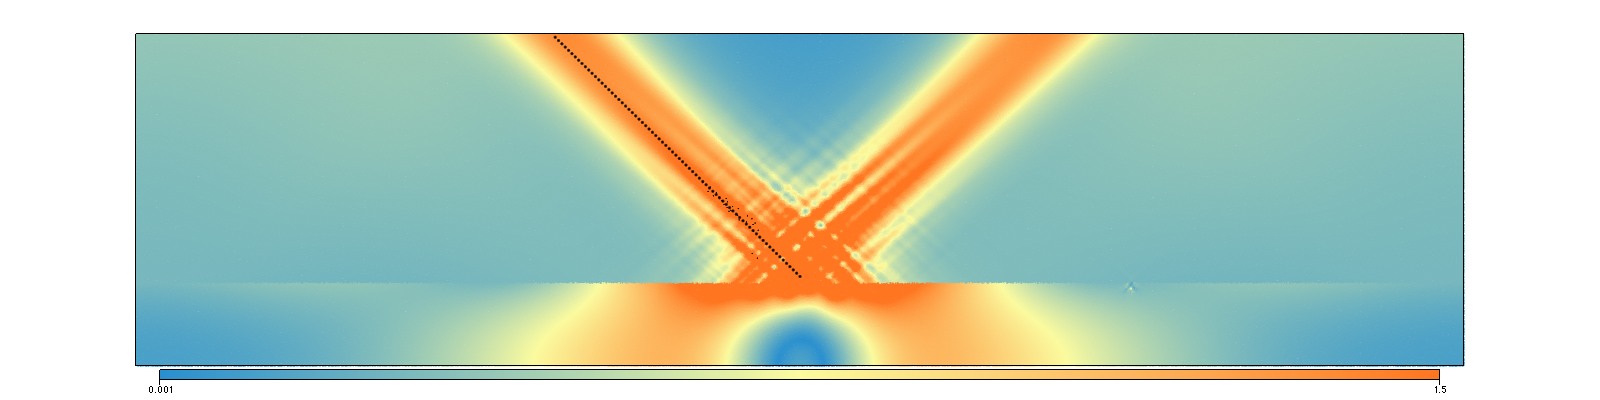

'results/T/0/images/figTest2.png'

In [405]:
figTest2 = glucifer.Figure( figsize=(1600,400), boundingBox=((-2.0, 0.0, 0.0), (2.0, 1.0, 0.0)) )
figTest2.append( glucifer.objects.Points(shearbandswarm, pointSize=2.0, colourBar=False) )

figTest2.append( glucifer.objects.Points(swarmCustom , pointSize=4.0,colourBar=False) )

figTest2.append( glucifer.objects.Points(swarm,strainRate_2ndInvariantFn, pointSize=3.0, valueRange=[1e-3, 1.5]) )

#figTest2.show()

figTest2.save_image(imagePath +  "figTest2.png")


In [152]:
import csv

if uw.rank()==0:

    someVals = [rmsint, shearArea ,shearPressure, 
                backgroundArea, backgroundPressure, viscmin, viscmax, eiimin, eiimax, angle,vdint, shearVd, backgroundVd, pressmin, pressmax  ] 

    with open(os.path.join(outputPath, 'metrics.csv'), 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(someVals)
    with open(os.path.join(outputPath, 'solver.csv'), 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(res1Vals)
        writer.writerow(res2Vals)
        writer.writerow(res3Vals)
    with open(os.path.join(outputPath, 'params.csv'), 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=",")
        writer.writerow(sorted(dp.values()))
        writer.writerow(sorted(ndp.values()))
        writer.writerow(sorted(md.values()))

NameError: name 'rmsint' is not defined

test = np.array([0.5, 0.5])

ys = np.linspace(0, 1, 10)
xs = np.zeros(10)

points = np.column_stack((xs, ys))


ix, weights = nn_evaluation(swarm, points, n=1, weighted=False)
ix, weights

visc = viscosityFn.evaluate(swarm)[ix]


%pylab inline
plt.scatter(ys, visc)